# Использование BERT для задачи классификации последовательности



## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face

In [1]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.1 MB/s eta 0:00:00


In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.2.2
torch       : 2.5.1+cu121
transformers: 4.47.1



Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [3]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 10.2MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 42.3MB/s]


In [4]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [6]:
df = pd.read_csv("reviews.csv")

In [7]:
df.shape

(15746, 11)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [9]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [10]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Посмотрим на распределение классов в выборке

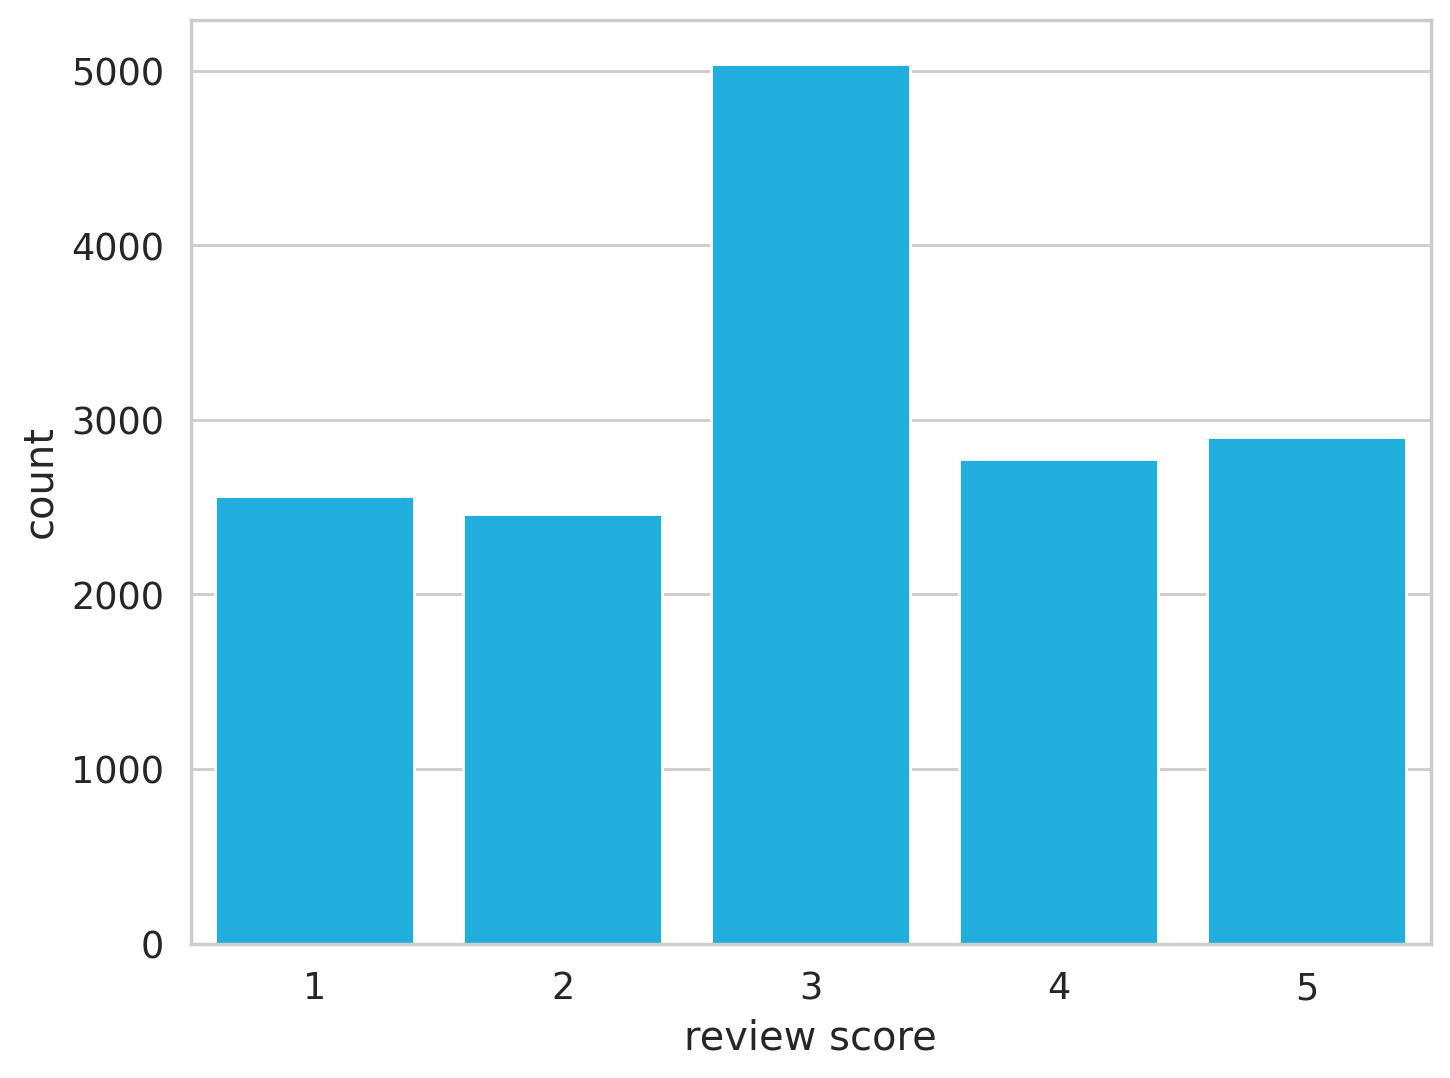

In [11]:
sns.countplot(x=df.score)
plt.xlabel('review score');

Можно видеть, что данные несбалансированы.
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [12]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [13]:
df

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15741,Tammy Kay,https://lh3.googleusercontent.com/a-/AOh14GhYP...,I believe that this is by far the best app wit...,5,0,NaN,2018-02-17 06:09:03,NaN,NaN,newest,com.appxy.planner,2
15742,Ysm Johan,https://lh3.googleusercontent.com/a-/AOh14Ggmd...,It sometimes crashes a lot!!,5,0,4.3.7,2018-02-15 10:45:22,NaN,NaN,newest,com.appxy.planner,2
15743,casey dearden,https://lh3.googleusercontent.com/a-/AOh14Gg2U...,Works well for what I need,5,0,4.3.7,2018-02-09 18:40:37,NaN,NaN,newest,com.appxy.planner,2
15744,Jerry G Tamate,https://lh3.googleusercontent.com/a-/AOh14GiTP...,Love it.,5,0,NaN,2018-02-06 12:36:17,NaN,NaN,newest,com.appxy.planner,2


In [14]:
class_names = ['negative', 'neutral', 'positive']

<ipython-input-15-c8622670199a>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names);


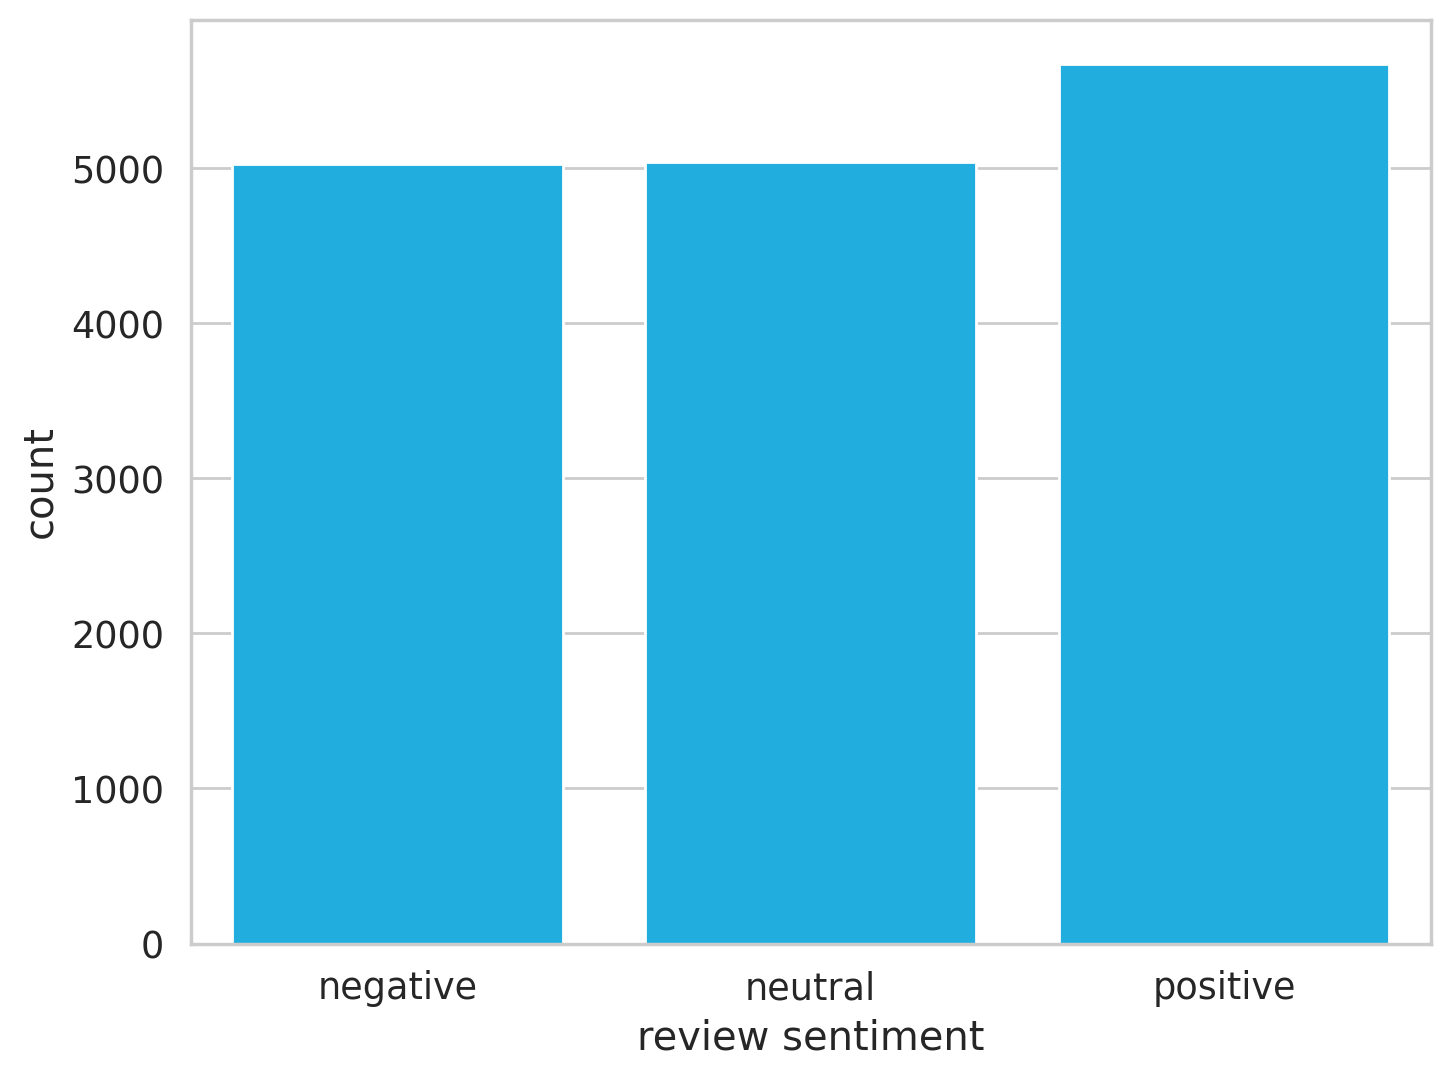

In [15]:
ax = sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [17]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Посмотрим, как работает модель токенизации для BERT.



In [18]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [19]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: He started a new book, it was quite readable
   Tokens: ['He', 'started', 'a', 'new', 'book', ',', 'it', 'was', 'quite', 'read', '##able']
Token IDs: [1124, 1408, 170, 1207, 1520, 117, 1122, 1108, 2385, 2373, 1895]




`[SEP]` - метка конца предложения


In [20]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

In [21]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Также существует специальный вспомогательный токен для выравнивания длин последовательностей

In [22]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Вся эта предобработка может быть сделана с помощью метода encode_plus

In [23]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1124, 1408,  170, 1207, 1520,  117, 1122, 1108, 2385, 2373, 1895,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Такая же длина будет и у *attention mask*

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


['[CLS]',
 'He',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Установим максимальную длину последовательности равной 160

In [27]:
MAX_LEN = 160

Теперь создадим датасет PyTorch, который понадобится в дальнейшем для обучения модели

In [28]:

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, тестовую и валидационную выборки

In [29]:
RANDOM_SEED = 12345
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
device

device(type='cuda', index=0)

In [31]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [32]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))


Создадим итераторы по данным
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [35]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из нашего итератора train_data_loader



In [36]:
data = next(iter(train_data_loader))

In [37]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['review_text'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

["I had a problem with upgrading to Premium. They were quick with their response and fixed the problem right away. It's a good app for those familiar with the Franklin Covey system, and syncs well across devices.", 'Same issue as Don Smith who wrote a review on 10/10/19. Will consider this app but the lack of slide visuals and character visuals makes the app in-op. Current phone is the Google pixel 4xl......perhaps I misspoke in regards to the reply. My issue is not with the visuals but the lack of visuals. Everything is blank for me so literally can not see half of the content.', "I actually really love this app. I used it to create some serious personal progress. I purchased the full app but when I bought a new phone, it wouldn't let me sign out of my old device and into my new device. I emailed support about it...crickets. Never heard from them. If they can put together a decent support team I would give the app a 5 for sure.", 'But of a downgrade from wunderlist. Please add a butto

In [39]:
data['targets']

tensor([2, 0, 1, 1, 2, 2, 0, 1, 1, 1, 0, 1, 2, 2, 2, 2])

## Классификация сентимента с использованием модели BERT от Hugging Face


В библиотеке Transformers от Hugging Face есть много моделей для разных задач: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) и другие. Все они являются надстройками над базовой моделью BERT.

В данном случае мы будем использовать базовую модель [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и реализуем на её основе свой классификатор текстов по тональности.

In [40]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [41]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'He',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [42]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [43]:
last_hidden_state, pooled_output, hidden_states = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  output_hidden_states=True,
  return_dict=False)


В переменную last_hidden_state теперь записана последовательность скрытых состояний последнего слоя модели.

In [44]:
print(last_hidden_state.shape)
print(pooled_output.shape)
print(len(hidden_states))

torch.Size([1, 32, 768])
torch.Size([1, 768])
13


In [45]:
for state in hidden_states:
  print(state.shape)

torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])


Посмотрим на BERT эмбеддинги некоторых слов в предложениях.

In [46]:
text1 = df.loc[16]['content']
text2 = df.loc[338]['content']
print(text1)
print(text2)

Couldn't even set up one single recurring reminder without being required to pay monthly subscription. Get your greedy hand off it dev. It's only only a reminder app not a useful service.
Well designed and all however alot of the crutial features are locked behind the premium which u need to pay for


In [47]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer2 = PreTrainedTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [48]:
tokenizer2.sep_token = tokenizer.sep_token
tokenizer2.pad_token = tokenizer.pad_token

In [49]:
encoding = tokenizer.encode_plus(
  text1,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

In [50]:
encoding2 = tokenizer2.encode_plus(
  text1,
  max_length=50,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True,
  return_offsets_mapping=True
)

In [51]:
print(encoding.keys())
print(encoding2.keys())

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask', 'offset_mapping'])


In [52]:
encoding2['offset_mapping']

tensor([[[  0,   0],
         [  0,   6],
         [  6,   7],
         [  7,   8],
         [  9,  13],
         [ 14,  17],
         [ 18,  20],
         [ 21,  24],
         [ 25,  31],
         [ 32,  41],
         [ 42,  50],
         [ 51,  58],
         [ 59,  64],
         [ 65,  73],
         [ 74,  76],
         [ 77,  80],
         [ 81,  88],
         [ 89, 101],
         [101, 102],
         [103, 106],
         [107, 111],
         [112, 118],
         [119, 123],
         [124, 127],
         [128, 130],
         [131, 133],
         [133, 134],
         [134, 135],
         [136, 138],
         [138, 139],
         [139, 140],
         [141, 145],
         [146, 150],
         [151, 152],
         [153, 161],
         [162, 165],
         [166, 169],
         [170, 171],
         [172, 178],
         [179, 186],
         [186, 187],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0

In [53]:
encoding['input_ids']

tensor([[  101, 23320,   112,   189,  1256,  1383,  1146,  1141,  1423, 10993,
         15656,  1443,  1217,  2320,  1106,  2653,  7868, 16759,   119,  3949,
          1240, 24007,  1289,  1228,  1122,  1260,  1964,   119,  1135,   102]])

In [54]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict=False)

In [55]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Couldn', "'", 't', 'even', 'set', 'up', 'one', 'single', 'recurring', 'reminder', 'without', 'being', 'required', 'to', 'pay', 'monthly', 'subscription', '.', 'Get', 'your', 'greedy', 'hand', 'off', 'it', 'de', '##v', '.', 'It', '[SEP]']


In [56]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')

17

In [57]:
emb1 = last_hidden_state[0, 17]
emb1.shape

torch.Size([768])

In [58]:
encoding2 = tokenizer.encode_plus(
  text2,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

last_hidden_state2, pooled_output2 = bert_model(
  input_ids=encoding2['input_ids'],
  attention_mask=encoding2['attention_mask'],
  return_dict=False)

In [59]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0])

['[CLS]',
 'Well',
 'designed',
 'and',
 'all',
 'however',
 'al',
 '##ot',
 'of',
 'the',
 'c',
 '##ru',
 '##tial',
 'features',
 'are',
 'locked',
 'behind',
 'the',
 'premium',
 'which',
 'u',
 'need',
 'to',
 'pay',
 'for',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [60]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0]).index('premium')

18

In [61]:
emb2 = last_hidden_state2[0, 1]
emb2.shape

torch.Size([768])

In [62]:
from sklearn.metrics.pairwise import cosine_similarity

In [63]:
cosine_similarity( [emb1.detach().cpu().numpy()], [emb2.detach().cpu().numpy()])

array([[0.5046449]], dtype=float32)

## SentimentClassifierWithCLS

Модель предназначена для классификации текста и строится вокруг предобученной модели bert-base-uncased, которая извлекает эмбеддинг CLS-токена с последнего слоя. CLS-токен — это первый токен каждой последовательности, предназначенный для обобщения информации о тексте. После извлечения этого эмбеддинга (`outputs[0][:, 0, :]`), содержащего информацию обо всей последовательности, он передаётся через последовательность дополнительных слоёв. Сначала применяется Dropout, затем линейный слой преобразует размерность CLS-эмбеддинга из hidden_size в 256. За слоем используется функция активации GELU. Далее слой Batch Normalization стабилизирует распределение выходных данных, ускоряя сходимость модели. После этого применяется ещё один слой Dropout. Финальный линейный слой преобразует выход размерностью 256 в количество классов, равное n_classes, генерируя логиты, которые можно использовать для предсказания классов.

In [64]:
class SentimentClassifierWithCLS(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)  # Первый полносвязный слой
        self.act1 = nn.GELU()  # Используем GELU
        self.bn1 = nn.BatchNorm1d(256)  # Нормализация
        self.drop2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(256, n_classes)  # Финальный полносвязный слой

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        cls_token_output = outputs[0][:, 0, :]  # Эмбеддинг CLS-токена
        x = self.drop1(cls_token_output)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.drop2(x)
        logits = self.fc2(x)
        return logits


In [82]:
'''class SentimentClassifierWithCLS(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.cls_dropout = nn.Dropout(p=0.3)
        self.cls_fc = nn.Linear(self.bert.config.hidden_size, 256)

        # Дополнительная обработка CLS
        self.cls_bn = nn.BatchNorm1d(256)
        self.cls_activation = nn.GELU()

        # Вторичный механизм внимания (на случай работы с CLS и глобальным контекстом)
        self.global_attention = nn.MultiheadAttention(
            embed_dim=self.bert.config.hidden_size,
            num_heads=4,
            batch_first=True
        )
        self.global_fc = nn.Linear(self.bert.config.hidden_size, 128)
        self.global_bn = nn.BatchNorm1d(128)
        self.global_activation = nn.GELU()
        self.global_dropout = nn.Dropout(p=0.3)

        # Итоговый слой классификации
        self.final_fc = nn.Linear(256 + 128, n_classes)

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)

        # Работа с CLS-токеном
        cls_token_output = bert_outputs[0][:, 0, :]  # Выход CLS
        cls_output = self.cls_dropout(cls_token_output)
        cls_output = self.cls_fc(cls_output)
        cls_output = self.cls_bn(cls_output)
        cls_output = self.cls_activation(cls_output)

        # Глобальный механизм внимания
        token_outputs = bert_outputs[0]  # Все токены
        global_attn_output, _ = self.global_attention(token_outputs, token_outputs, token_outputs)
        global_avg_output = torch.mean(global_attn_output, dim=1)  # Среднее по токенам
        global_output = self.global_fc(global_avg_output)
        global_output = self.global_bn(global_output)
        global_output = self.global_activation(global_output)
        global_output = self.global_dropout(global_output)

        # Конкатенация CLS и глобального внимания
        combined_output = torch.cat([cls_output, global_output], dim=1)
        logits = self.final_fc(combined_output)
        return logits'''

In [83]:
model = SentimentClassifierWithCLS(len(class_names))
model = model.to(device)

Перенесем на GPU один из наших батчей.

In [84]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


Применим модель к данным.

In [85]:
output = model(input_ids, attention_mask)
output

tensor([[ 1.5124e-01, -1.6752e-01,  5.9179e-01],
        [-5.0108e-01,  2.0399e-01, -4.7945e-04],
        [-4.0575e-01, -2.1446e-01, -2.2335e-01],
        [-6.3263e-02,  9.1564e-01, -4.1349e-01],
        [ 2.0425e-02, -2.1320e-01,  5.7849e-01],
        [-4.2428e-01,  1.3245e+00, -2.3598e-01],
        [-1.5681e-01, -1.4001e-01, -4.7840e-01],
        [ 1.7877e-01,  6.6322e-01,  5.3977e-02],
        [-1.9317e-01,  1.9773e-01, -3.7629e-02],
        [-6.4604e-02,  3.0030e-01, -1.8003e-01],
        [ 5.3565e-02, -9.7673e-03,  7.8123e-01],
        [ 4.8270e-02,  3.8612e-01, -2.6762e-01],
        [-6.8922e-01,  8.5663e-01, -3.6646e-01],
        [ 1.4669e-01,  3.3295e-01, -2.4845e-01],
        [-4.2600e-01, -9.2577e-02, -3.5122e-01],
        [-2.6837e-01, -2.3897e-01, -7.2986e-02]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Если хотим получить вероятности классов, применяем SoftMax к выходу модели.

In [86]:
F.softmax(output, dim=1)

tensor([[0.3048, 0.2216, 0.4736],
        [0.2140, 0.4331, 0.3530],
        [0.2932, 0.3550, 0.3518],
        [0.2290, 0.6096, 0.1614],
        [0.2826, 0.2237, 0.4937],
        [0.1257, 0.7225, 0.1518],
        [0.3647, 0.3709, 0.2644],
        [0.2852, 0.4630, 0.2518],
        [0.2742, 0.4054, 0.3204],
        [0.3002, 0.4324, 0.2675],
        [0.2494, 0.2341, 0.5164],
        [0.3194, 0.4477, 0.2329],
        [0.1414, 0.6634, 0.1952],
        [0.3474, 0.4186, 0.2340],
        [0.2879, 0.4018, 0.3103],
        [0.3081, 0.3173, 0.3746]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Обучение модели


Для дообучения модели будем использовать оптимизатор [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Hugging Face.



Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [87]:

#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False


In [88]:
list(model.bert.encoder.layer[3].parameters())[0]

Parameter containing:
tensor([[ 0.0586, -0.0279,  0.0022,  ..., -0.0205,  0.0419,  0.0560],
        [-0.0011,  0.1283, -0.0564,  ..., -0.0514, -0.0199,  0.0516],
        [-0.0083,  0.0060, -0.0469,  ...,  0.0569, -0.0073, -0.0616],
        ...,
        [ 0.0118,  0.0645, -0.0159,  ..., -0.0027, -0.0031, -0.0141],
        [ 0.0029,  0.0531,  0.0221,  ..., -0.0047,  0.0399,  0.0344],
        [ 0.0512,  0.0246,  0.0077,  ...,  0.0108,  0.0262,  0.0081]],
       device='cuda:0')

In [89]:
EPOCHS = 2

#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Реализуем функцию для одной эпохи обучения

In [90]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

Также реализуем функцию для оценки качества модели на данных из data_loader

In [91]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

Используя эти две функции, описанные выше, реализуем процедуру дообучения нашей модели

In [92]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.9319682646685744 accuracy 0.5373650789260864
Val loss 0.7869494938850403 accuracy 0.6200762391090393

Epoch 2/2
----------
Train loss 0.7391023403769422 accuracy 0.6683367490768433
Val loss 0.7414180171489716 accuracy 0.6581956744194031

CPU times: user 8min 56s, sys: 2min 35s, total: 11min 32s
Wall time: 11min 49s



При обучении модели мы сохраняем веса наилучшей модели на основе точности на валидационной выборке.

Обучение модели занимает некоторое время. Теперь мы можем сравнить точность на валидационной и на обучающей выборке.

In [93]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

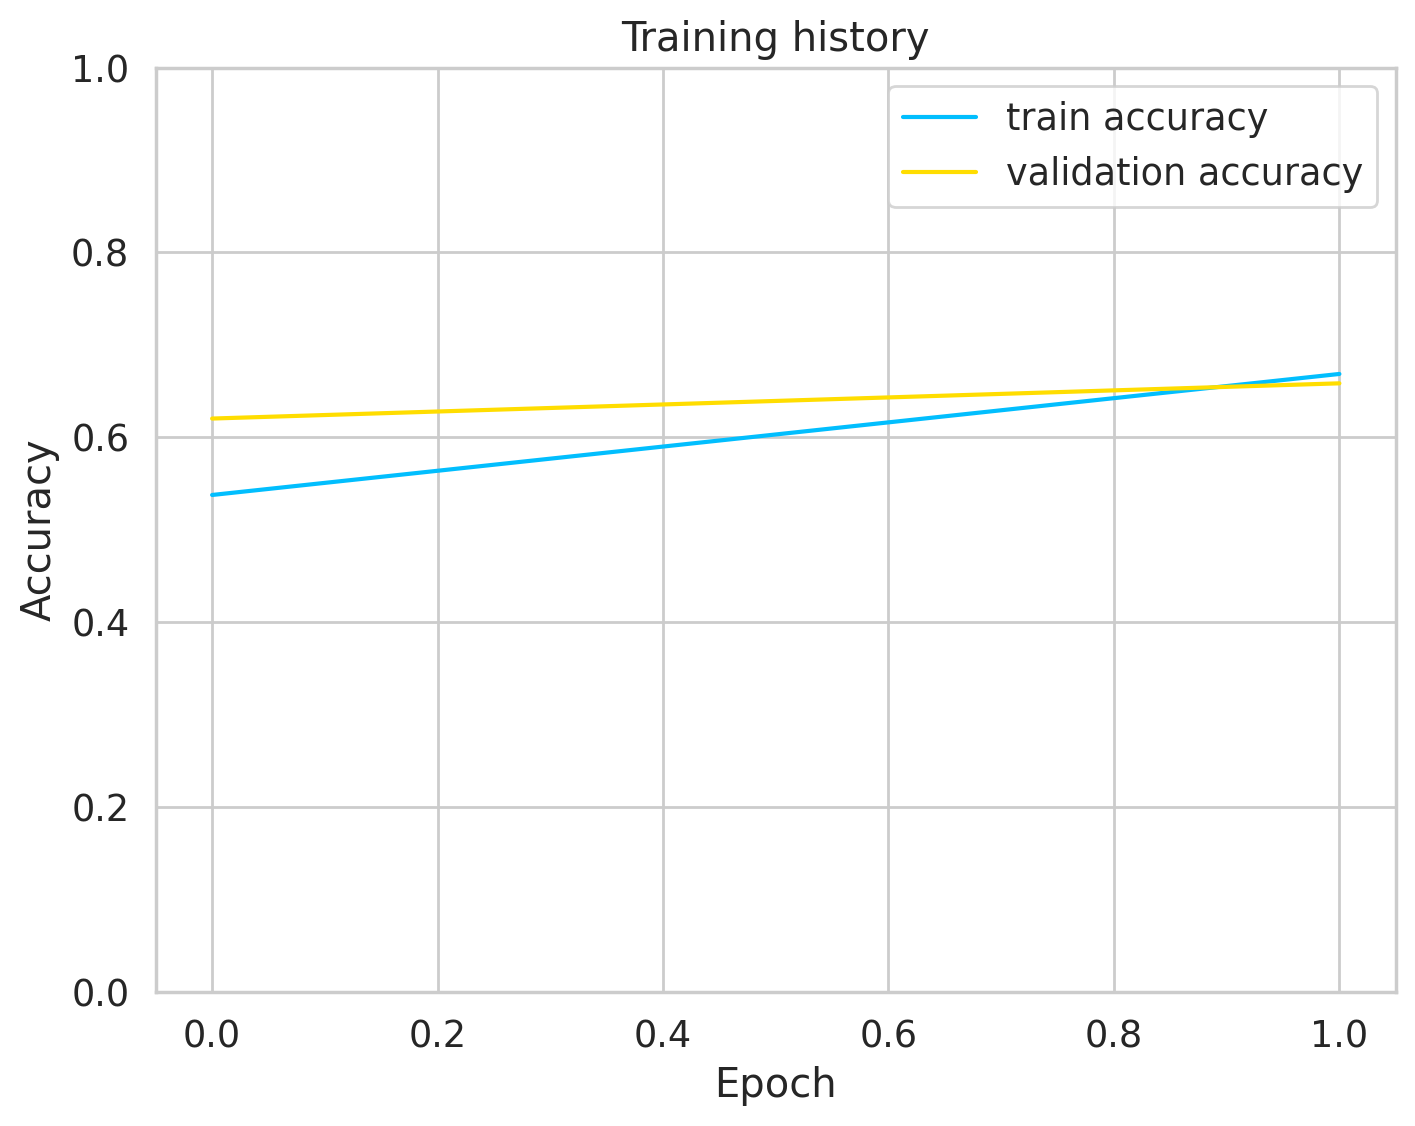

In [94]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Оценка результатов работы модели

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [95]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6472080945968628

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. КОнечно, результаты не стольо впечатляющие, по сравнению с моделью без cls-токенов, поэтому, если не стоит задача с четкой архитектурой, то классическая модель в несколько слоев даст получше результат.

Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [79]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [80]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [81]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.71      0.63      0.67       262
     neutral       0.50      0.51      0.51       235
    positive       0.74      0.79      0.76       291

    accuracy                           0.65       788
   macro avg       0.65      0.65      0.65       788
weighted avg       0.66      0.65      0.65       788



Из данного отчета видно, что сложнее всего классифицировать нейтральные отзывы. Также как и на обычном SentimentClassifier

Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

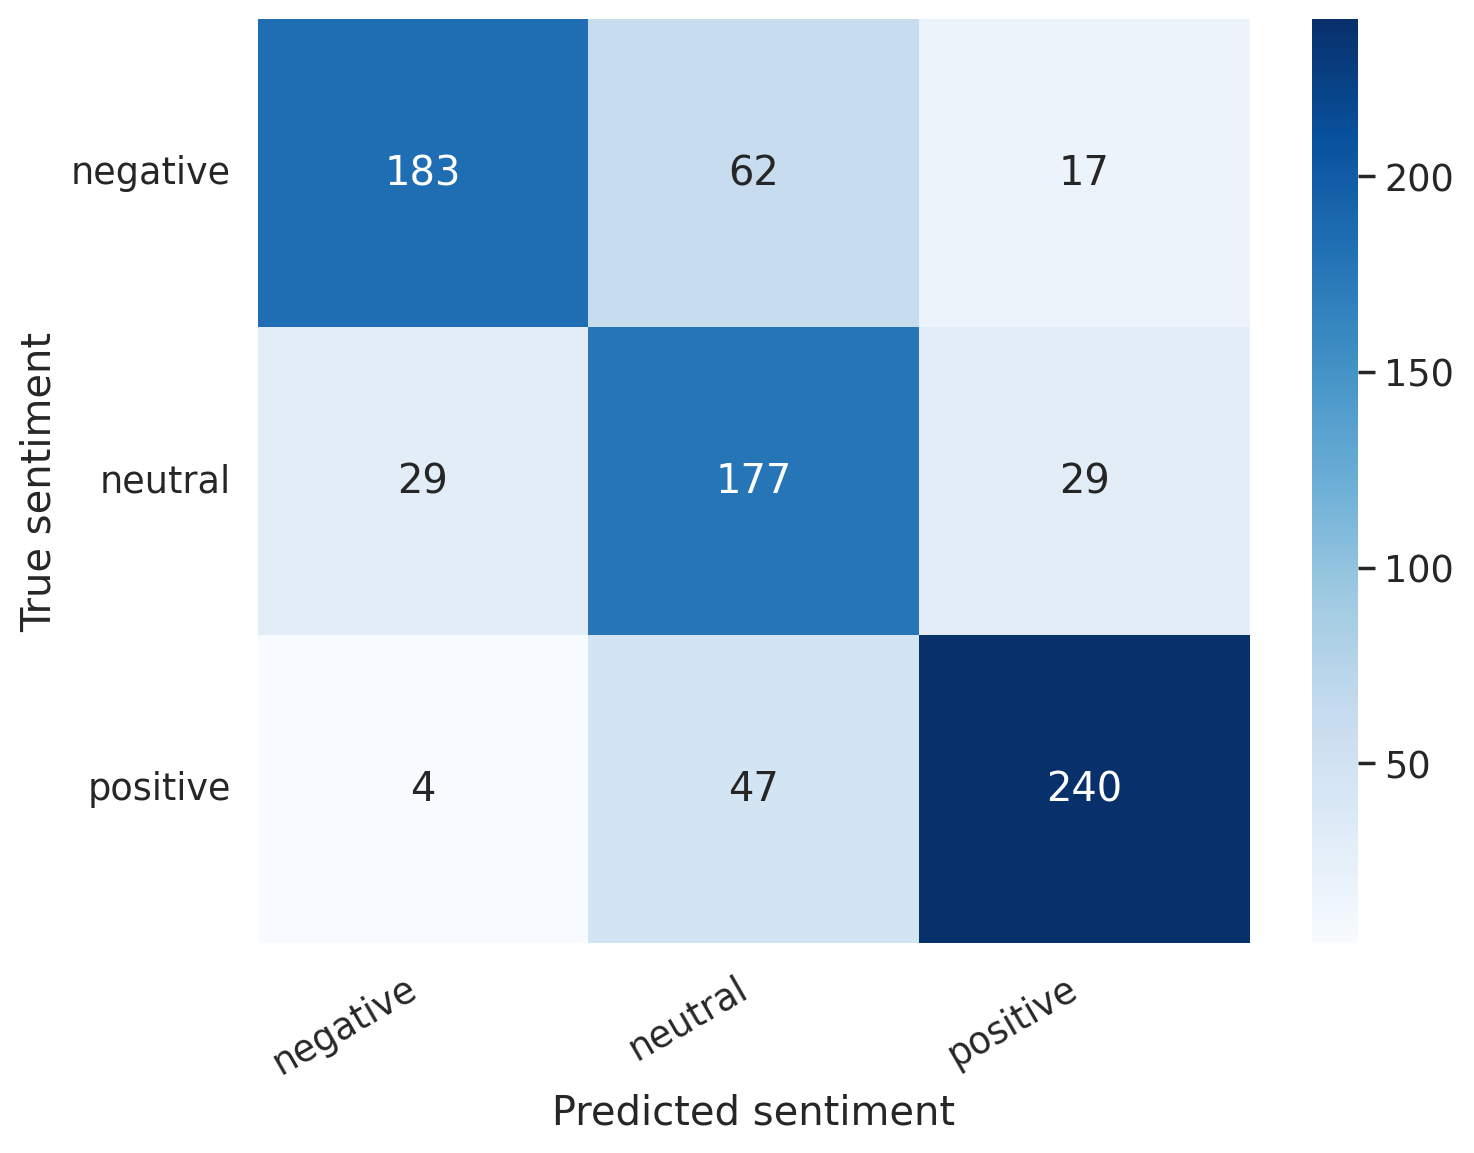

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы.

## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


## SentimentClassifier классический

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:

#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False


In [ ]:
list(model.bert.encoder.layer[3].parameters())[0]

Parameter containing:
tensor([[ 0.0408,  0.0030,  0.0493,  ..., -0.0447,  0.0018,  0.0092],
        [-0.0179,  0.0101,  0.0018,  ..., -0.0078,  0.0205,  0.0202],
        [ 0.0064, -0.0355,  0.0388,  ...,  0.0118,  0.0331, -0.0531],
        ...,
        [ 0.1221, -0.0232,  0.1091,  ..., -0.0366, -0.0166,  0.0676],
        [-0.0261,  0.0560,  0.0429,  ...,  0.0124, -0.0057, -0.0347],
        [ 0.0665, -0.0589,  0.0258,  ...,  0.0240,  0.0202,  0.0290]],
       device='cuda:0')

In [ ]:
EPOCHS = 2

#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.7383771038216878 accuracy 0.6622680425643921
Val loss 0.590901095867157 accuracy 0.7496823072433472

Epoch 2/2
----------
Train loss 0.49971718990304936 accuracy 0.8007903695106506
Val loss 0.540781512260437 accuracy 0.7827191352844238

CPU times: user 8min 24s, sys: 1min 46s, total: 10min 10s
Wall time: 10min 27s


In [ ]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

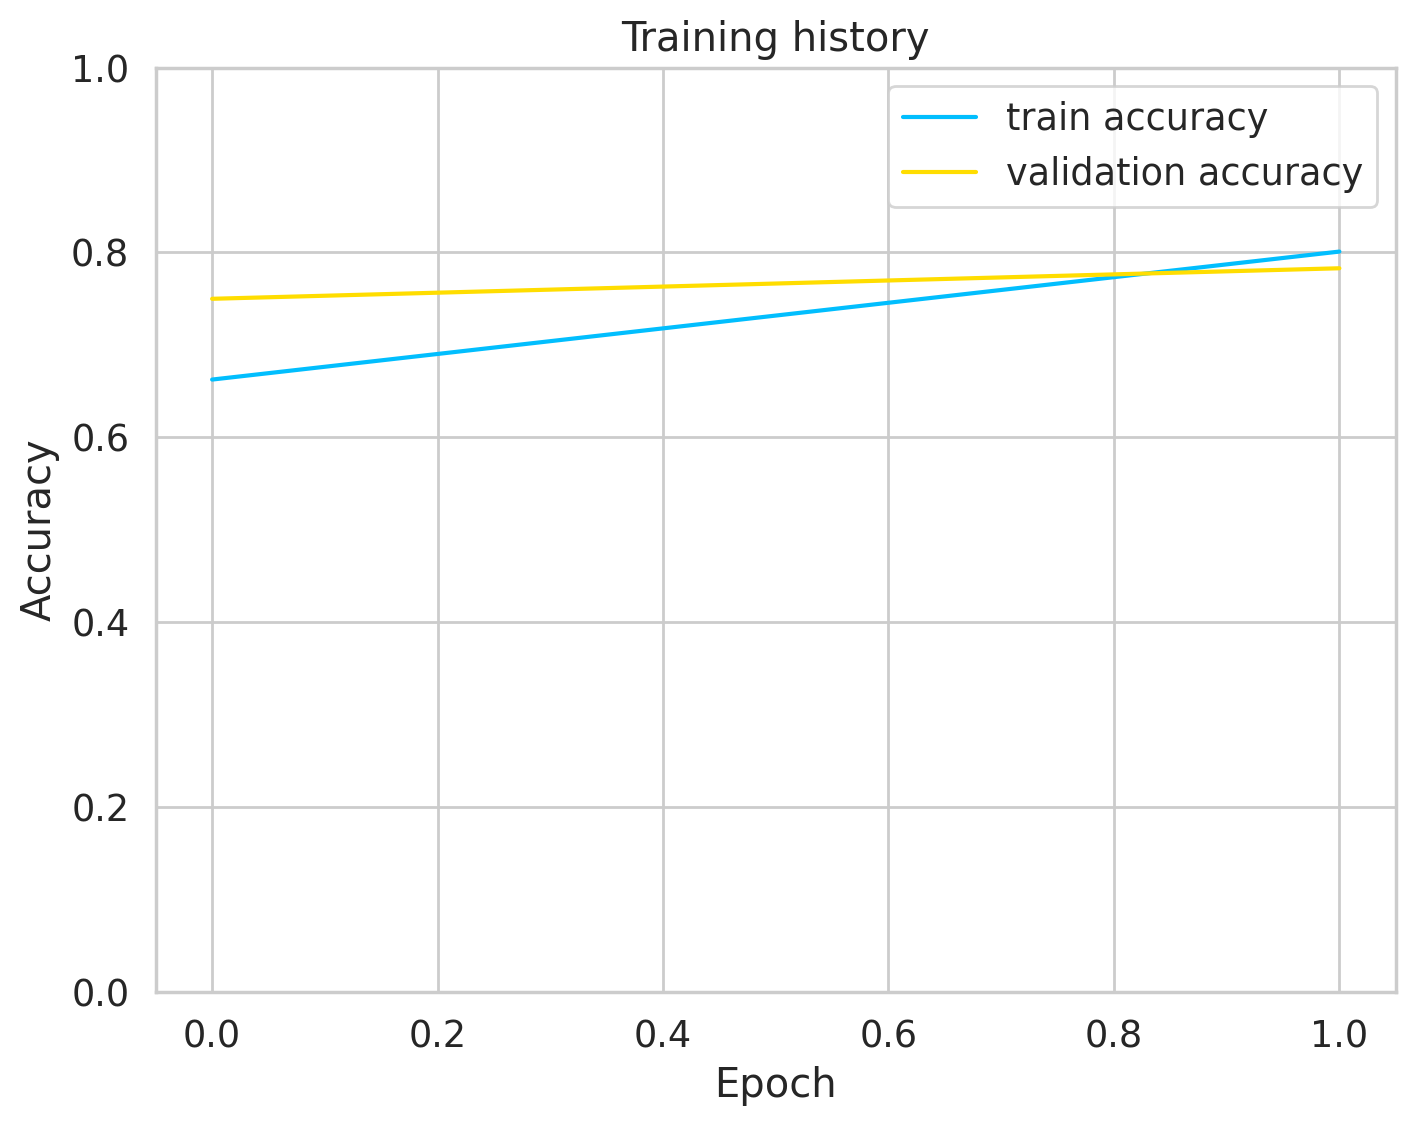

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.760152280330658

Так, валидация показывает хорошие результаты, что скажет тест.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.82      0.72      0.76       262
     neutral       0.63      0.70      0.67       235
    positive       0.83      0.85      0.84       291

    accuracy                           0.76       788
   macro avg       0.76      0.76      0.76       788
weighted avg       0.77      0.76      0.76       788



Это самый лучший результат. Модель также лучше всех классифицирует положительные отзывы. Сложнее всего ей даются нейтральные. Оно и очевидно, нет явных маркеров, чтобы отнести текст к нейтральному.

## BertForSequenceClassification

Теперь обучим уже готовую модель BertForSequenceClassification, ради которой мне пришлось зарегаться на сайте.

In [125]:
from transformers import BertTokenizer, BertForSequenceClassification

In [126]:
CUDA_LAUNCH_BLOCKING=1

In [127]:
print(f"Unique labels in training data: {set(df_train['sentiment'])}")

Unique labels in training data: {0, 1, 2}


In [128]:
# Инициализация модели
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(class_names)  # Число классов
)
model = model.to(device)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
# Заморозка первых 5 слоев
freeze_layers = list(range(5))
for layer_id in freeze_layers:
    for param in model.bert.encoder.layer[layer_id].parameters():
        param.requires_grad = False


In [130]:
# Оптимизатор и планировщик
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
EPOCHS = 2
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [131]:
# Функция потерь
loss_fn = nn.CrossEntropyLoss().to(device)

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits  # Логиты из выхода модели
        preds = torch.argmax(logits, dim=1)
        loss = loss_fn(logits, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [132]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            loss = loss_fn(logits, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [133]:
# Обучение
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------
Train loss 1.0741347425005505 accuracy 0.40081857314233293
Val loss 0.9749951708316803 accuracy 0.5209656925031766

Epoch 2/2
----------
Train loss 0.9406299595100885 accuracy 0.5240985110436808
Val loss 0.9089492857456207 accuracy 0.5336721728081322



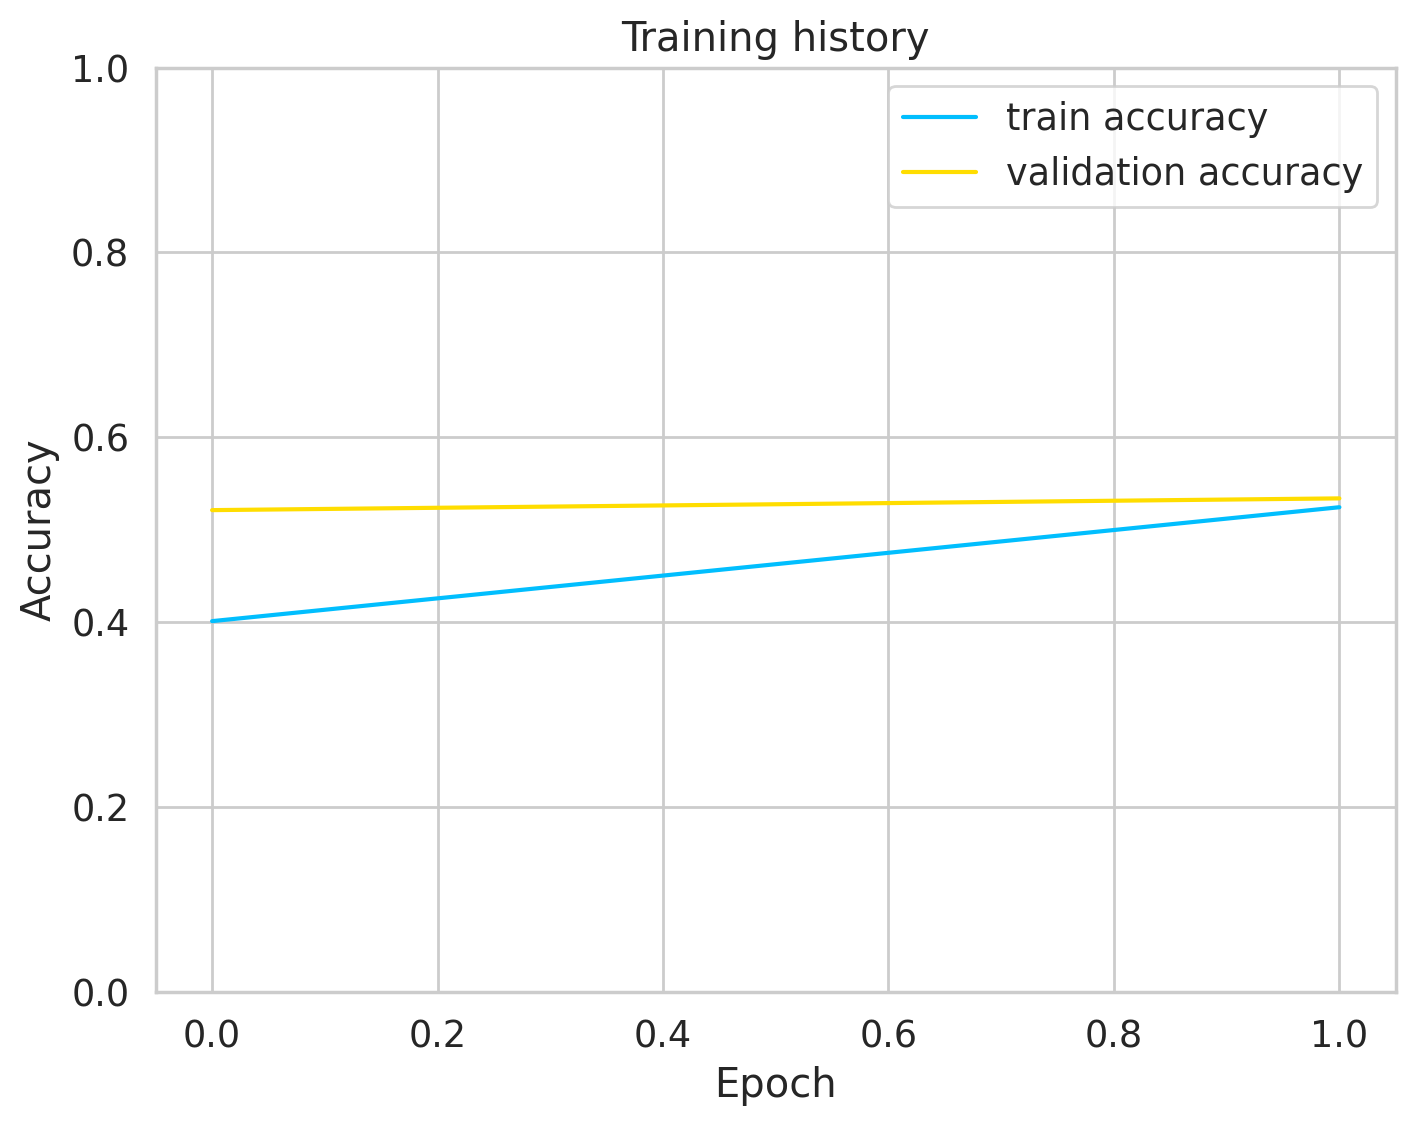

Test Accuracy: 0.549492385786802


In [134]:
# Визуализация истории обучения
history['train_acc'] = [score.to('cpu') for score in history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in history['val_acc']]

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Оценка на тестовом наборе
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

print(f'Test Accuracy: {test_acc.item()}')

In [135]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      logits = outputs.logits
      preds = torch.argmax(logits, dim=1)
      probs = F.softmax(logits, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [136]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [137]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.58      0.52      0.55       262
     neutral       0.42      0.24      0.31       235
    positive       0.57      0.83      0.68       291

    accuracy                           0.55       788
   macro avg       0.53      0.53      0.51       788
weighted avg       0.53      0.55      0.52       788



Модель демонстрирует умеренные результаты с общей точностью 55%.
Наиболее успешной модель оказалась в классификации положительных примеров positive, как иу остальных моделей.
Наименее успешным оказался класс neutral.

## Модель с агрегацией CLS-токенов


Все плюс-минус то же самое, те же гиперпараметры. но поменяем архитектуру.

In [108]:
class AggregatedCLSClassifier(nn.Module):
    def __init__(self, n_classes, num_agg_layers=4):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.num_agg_layers = num_agg_layers  # Число слоев для агрегации

        self.cls_fc = nn.Linear(self.bert.config.hidden_size * num_agg_layers, 256)
        self.cls_dropout = nn.Dropout(p=0.3)
        self.cls_bn = nn.BatchNorm1d(256)
        self.cls_activation = nn.GELU()

        self.final_fc = nn.Linear(256, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        # Извлечение скрытых состояний из последних num_agg_layers
        hidden_states = outputs.hidden_states[-self.num_agg_layers:]  # Список тензоров размером [batch_size, seq_length, hidden_size]

        # Агрегация CLS-токенов из выбранных слоев
        cls_tokens = [state[:, 0, :] for state in hidden_states]  # Получаем CLS-токен из каждого слоя
        aggregated_cls = torch.cat(cls_tokens, dim=-1)  # Конкатенация CLS-токенов (размер: [batch_size, hidden_size * num_agg_layers])

        # Обработка агрегированного CLS
        cls_output = self.cls_dropout(aggregated_cls)
        cls_output = self.cls_fc(cls_output)
        cls_output = self.cls_bn(cls_output)
        cls_output = self.cls_activation(cls_output)

        # Итоговое предсказание
        logits = self.final_fc(cls_output)
        return logits

In [109]:
model = AggregatedCLSClassifier(len(class_names))
model = model.to(device)

In [110]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [111]:
output = model(input_ids, attention_mask)
output

tensor([[-0.6579, -0.4825,  0.9872],
        [ 0.1520,  0.1943, -0.6938],
        [ 0.3233,  0.6217, -0.5277],
        [ 0.1930,  0.3705, -0.3178],
        [ 0.0402,  0.6746, -0.3603],
        [-0.1056,  0.2457,  0.5925],
        [ 0.1171,  0.0845,  0.1594],
        [-0.4403,  0.6246, -0.2032],
        [ 0.2296,  0.7636, -0.2184],
        [-0.3058,  0.1274, -0.3172],
        [-0.8603, -0.1703, -0.6306],
        [ 0.6987,  0.3775, -0.4391],
        [ 0.1187,  0.7248,  0.1535],
        [-0.1957, -0.2016, -0.4012],
        [-0.3613,  0.2565, -0.2783],
        [-0.0480,  0.1728, -0.1400]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [112]:
F.softmax(output, dim=1)

tensor([[0.1356, 0.1616, 0.7028],
        [0.4045, 0.4219, 0.1736],
        [0.3604, 0.4857, 0.1539],
        [0.3579, 0.4274, 0.2147],
        [0.2812, 0.5304, 0.1884],
        [0.2257, 0.3207, 0.4536],
        [0.3321, 0.3214, 0.3464],
        [0.1935, 0.5612, 0.2453],
        [0.2990, 0.5100, 0.1910],
        [0.2832, 0.4368, 0.2800],
        [0.2352, 0.4689, 0.2959],
        [0.4888, 0.3545, 0.1567],
        [0.2585, 0.4739, 0.2676],
        [0.3561, 0.3540, 0.2899],
        [0.2537, 0.4706, 0.2757],
        [0.3165, 0.3948, 0.2887]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [113]:

#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False


In [114]:
list(model.bert.encoder.layer[3].parameters())[0]

Parameter containing:
tensor([[ 0.0586, -0.0279,  0.0022,  ..., -0.0205,  0.0419,  0.0560],
        [-0.0011,  0.1283, -0.0564,  ..., -0.0514, -0.0199,  0.0516],
        [-0.0083,  0.0060, -0.0469,  ...,  0.0569, -0.0073, -0.0616],
        ...,
        [ 0.0118,  0.0645, -0.0159,  ..., -0.0027, -0.0031, -0.0141],
        [ 0.0029,  0.0531,  0.0221,  ..., -0.0047,  0.0399,  0.0344],
        [ 0.0512,  0.0246,  0.0077,  ...,  0.0108,  0.0262,  0.0081]],
       device='cuda:0')

In [115]:
EPOCHS = 2

#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [116]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

In [117]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

In [118]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.9636044981920961 accuracy 0.511961042881012
Val loss 0.7983583593368531 accuracy 0.6378653049468994

Epoch 2/2
----------
Train loss 0.7683521790711659 accuracy 0.6415214538574219
Val loss 0.7595442152023315 accuracy 0.6556543707847595

CPU times: user 8min 48s, sys: 1min 54s, total: 10min 42s
Wall time: 11min 4s


In [119]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

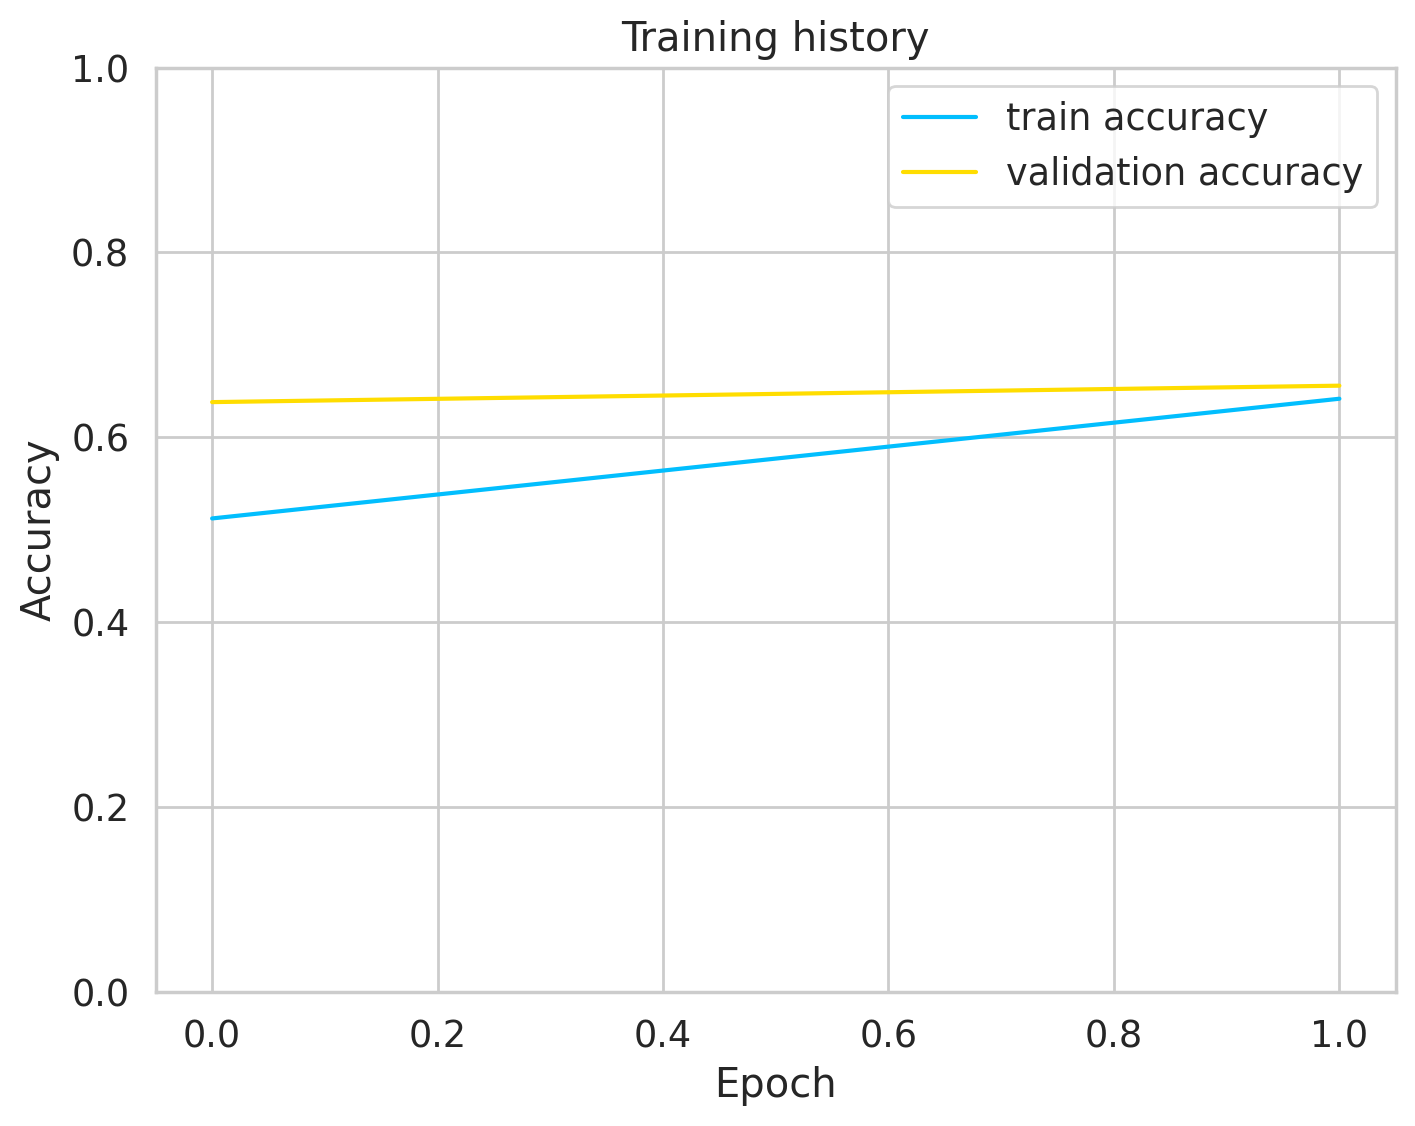

In [120]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [121]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6446700096130371

In [122]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [123]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [124]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.66      0.66      0.66       262
     neutral       0.51      0.45      0.48       235
    positive       0.71      0.79      0.75       291

    accuracy                           0.64       788
   macro avg       0.63      0.63      0.63       788
weighted avg       0.64      0.64      0.64       788



Accuracy составляет 0.64, что указывает на то, что модель правильно классифицирует примерно 64% примеров из тестового набора. Это на 1% меньше, чем у предыдущих моделей, и есть пространство для роста, особенно в классе neutral.